In [ ]:
#%pip install qiskit
#%pip install qiskit-ionq

import qiskit
import qiskit_ionq
from qiskit_ionq import IonQProvider

from qiskit import QuantumCircuit
from qiskit import transpile, assemble
from qiskit_ionq import IonQProvider

import math
import random
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize


# *********************** HIDE THIS BEFORE SHARING *********
provider = IonQProvider("")

# print(provider.get_backend('ionq_qpu.forte')) # we have access to forte!
backend = provider.get_backend('ionq_qpu.aria-2')
# backend = provider.get_backend('ionq_qpu.aria-1')
#backend = provider.get_backend('ionq_qpu.forte')
n_qubits = 3  # Number of system qubits.
acc = 3 # Number of digits of accuracy
n_shots = 10 ** (acc * 2)  # Number of quantum measurements.
tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).
q_delta = 0.1  # Initial spread of random quantum weights

eps = 0.01 # Required epsilon for minimizer thresholding

# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...
c = np.array([2.5, -1, -1, -0.5])

A_num = np.zeros((2**n_qubits, 2**n_qubits))
for idx in range(2**n_qubits):
    A_num[idx, idx] = 2

for m in range(2**n_qubits):
    for n in range(2**n_qubits):
        if abs(m - n) == 1:
            A_num[m, n] = -1

b = np.ones(8) / np.sqrt(8)

print("A = \n", np.real(A_num))
print("b = \n", b)
cond = np.linalg.cond(A_num)
print(str(cond))
A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)

c_probs = (x / np.linalg.norm(x)) ** 2

def CU_b():
    global circ
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        circ.ch(ancilla_idx, idx)

def U_b():
    global circ
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        circ.h(idx)

# Defines an C_i matrix, which will comprise an L2 matrix for the
# high-entanglement decomposition of the Poisson
def CI(i):
    global circ
    for j in range(i):
        circ.mcx([ancilla_idx, i], i-1-j, mode="noancilla")
    circ.mcx([ancilla_idx] + [x for x in range(i)], i, mode="noancilla")
    for j in range(i):
        circ.mcx([ancilla_idx, i], j, mode="noancilla")


# L3 tilda matrix for the high-entanglement decomposition of the poisson
def L3():
    global circ
    circ.h(ancilla_idx)
    circ.mcx([x for x in range(n_qubits)], ancilla_idx, mode="noancilla")
    circ.h(ancilla_idx)

    for i in range(n_qubits):
        circ.cx(ancilla_idx, i)

    circ.h(ancilla_idx)
    circ.mcx([x for x in range(n_qubits)], ancilla_idx, mode="noancilla")
    circ.h(ancilla_idx)

    for i in range(n_qubits):
        circ.cx(ancilla_idx, i)

def CA(idx):
    global circ
    """Controlled versions of the unitary components A_l of the problem matrix A."""
    if idx == 0:
        # Identity operation
        None

    elif idx == 1:
        # L1
        circ.cx(ancilla_idx, 0)

    elif idx == 2:
        # L2 matrix
        for i in range(1, n_qubits):
            CI(i)

    elif idx == 3:
        # L3tilda matrix
        L3()

#GEA
def variational_block(weights):
    global circ
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
    num_layers = 3

    U_b()

    # Using num_layers layers for variational ansatz
    for layer in range(num_layers):
        # Layer of rotation gates
        for idx, element in enumerate(weights[layer*n_qubits:(layer+1)*n_qubits]):
            circ.ry(element, idx)

        # Applying entanglement layer to all but the last layer
        if layer < (num_layers-1):
            for idx in range(n_qubits):
                # Essentially vary the entanglement by the number
                # of layers we choose for the ansatz.
                if layer != idx:
                    circ.cz(layer, idx)

def c_variational_block(weights):
    global circ
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
    num_layers = 3

    CU_b()

    # Using num_layers layers for variational ansatz
    for layer in range(num_layers):
        # Layer of rotation gates
        for idx, element in enumerate(weights[layer*n_qubits:(layer+1)*n_qubits]):
            circ.cry(element, ancilla_idx, idx)

        # Applying entanglement layer to all but the last layer
        if layer < (num_layers-1):
            for idx in range(n_qubits):
                # Essentially vary the entanglement by the number
                # of layers we choose for the ansatz.
                if layer != idx:
                    circ.h(ancilla_idx)
                    circ.mcx([layer, idx], ancilla_idx)
                    circ.h(ancilla_idx)

# For calculating < b | psi >
def had_one(weights, l, part):
    global circ
    circ = QuantumCircuit(n_qubits + 1, 1)

    circ.h(ancilla_idx)

    if part == "Im" or part == "im":
        circ.p(-np.pi / 2, ancilla_idx)

    # Initial state = | 0 >
    # Unitary to control = U_b_adj A_l V
    c_variational_block(weights)

    CA(l)

    CU_b()

    circ.h(ancilla_idx)

    circ.measure(ancilla_idx, 0)

    circ = transpile(circ, backend)
    print("Submitting job...")
    result = backend.run(circ, shots=n_shots).result()
    print("Job Finished.")
    output = result.get_counts(circ)
    o = (output['1'] / n_shots) if '1' in output.keys() else 0
    return (1 - 2*o)

def mu(weights, l):
    mu_real = had_one(weights, l, "Re")

    return mu_real

def b_psi_sq(weights):

    res = 0

    for l in range(len(c)):
        res += c[l] * mu(weights, l)

    return abs(res ** 2)

# For calculating < psi | psi >
def had_two(weights, l, lp, part):
    global circ
    circ = QuantumCircuit(n_qubits + 1, 1)

    circ.h(ancilla_idx)

    if part == "Im" or part == "im":
        circ.p(-np.pi / 2, ancilla_idx)

    # Initial state = V | 0 >
    variational_block(weights)

    # Unitary to control = A_lp_adj A_l
    CA(l)
    CA(lp) # Hermitian/Pauli matrices are self-adjoint

    circ.h(ancilla_idx)

    circ.measure(ancilla_idx, 0)

    circ = transpile(circ, backend)
    result = backend.run(circ, shots=n_shots).result()

    output = result.get_counts(circ)
    o = (output['1'] / n_shots) if '1' in output.keys() else 0
    return (1 - 2*o)

def beta(weights, l, lp):
    beta_real = had_two(weights, l, lp, "Re")
    return beta_real

def psi_psi(weights):

    res = 0

    # Add all l and lp s.t. l != lp and lp > l
    for l in range(len(c)):
        for lp in range(l+1, len(c)):
            res += 2 * c[l] * np.conj(c[lp]) * beta(weights, l, lp)

    # Add the remaining result of the summations
    for ind in range(len(c)):
        res += c[ind] * np.conj(c[ind])

    return abs(res)

def cost_loc(weights):
    global cost, w
    w = weights

    b_psi_sq_val = b_psi_sq(weights)
    psi_psi_val = psi_psi(weights)

    # Toss out runs where b_psi_sq is larger than psi_psi, as
    # we know that is physically impossible.
    while b_psi_sq_val > psi_psi_val:
        print("Tossing out non-physical values...")
        b_psi_sq_val = b_psi_sq(weights)
        psi_psi_val = psi_psi(weights)
    #print(b_psi_sq_val)
    #print(psi_psi_val)
    cost = 1 - (b_psi_sq_val/psi_psi_val)
    return cost


A = 
 [[ 2. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0. -1.  2.]]
b = 
 [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
32.16343747752639


In [ ]:
# TESTING MULTI-QUBIT SYSTEMS

from scipy.optimize import minimize

qubits_list = [x for x in range(3, 11)]
global w

class GammaCondition(Exception):
    pass

def log_cost(x):
    global cost, cost_history
    cost_history.append(cost)
    print(cost)
    if cost <= gamma:
        raise GammaCondition

cost_history_all = []
for q in qubits_list:
    cost_history = []
    print(q)
    w = q_delta * np.random.rand(3*q)

    n_qubits = q  # Number of system qubits.
    tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
    ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).

    A_num = np.zeros((2**n_qubits, 2**n_qubits))
    for idx in range(2**n_qubits):
        A_num[idx, idx] = 2

    for m in range(2**n_qubits):
        for n in range(2**n_qubits):
            if abs(m - n) == 1:
                A_num[m, n] = -1

    b = np.ones(2**q) / np.sqrt(2**q)

    print("A = \n", np.real(A_num))
    print("b = \n", b)
    cond = np.linalg.cond(A_num)
    print(str(cond))
    A_inv = np.linalg.inv(A_num)
    x = np.dot(A_inv, b)

    c_probs = (x / np.linalg.norm(x)) ** 2

    gamma = (eps ** 2) / (n_qubits * (cond ** 2))

    try:
        out = minimize(cost_loc, x0 = w, method='COBYLA', callback=log_cost)
    except GammaCondition:
        pass
    cost_history_all.append(cost_history)

3
A = 
 [[ 2. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0. -1.  2.]]
b = 
 [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
32.16343747752639
Submitting job...


IonQJobFailureError: IonQJobFailureError('Unable to retreive result for job 7e31a797-acb3-4bb4-b444-4f22217613c7. Failure from IonQ API "QuotaExhaustedError: exhausted spending quota of type (project)"')

In [ ]:
from scipy.optimize import minimize

gamma = (eps ** 2) / (cond ** 2)
print(gamma)
class GammaCondition(Exception):
    pass

def log_cost(x):
    global cost, cost_history
    cost_history.append(cost)
    print(cost)
    if cost <= gamma:
        raise GammaCondition

global w
#soln from
w = q_delta * np.random.rand(9)
#w = [-0.22296879,  1.39700563, -1.86268021, -1.69595003,  1.33466046,  0.58702013,
# -1.37133891, -0.31573189,  1.67787141]
cost_history = []
try:
    out = minimize(cost_loc, x0 = w, method="Powell", callback=log_cost)
    w = out.x
except GammaCondition:
    pass


plt.style.use("seaborn")
plt.plot(cost_history, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

Number of iterations:
1
Final weights:
[-0.22296879  1.39700563 -1.86268021 -1.69595003  1.33466046  0.58702013
 -1.37133891 -0.31573189  1.67787141]
{'000 000': 32435, '001 000': 99942, '010 000': 164179, '011 000': 203288, '100 000': 202837, '101 000': 164651, '110 000': 100029, '111 000': 32639}
x_n^2 =
 [0.03252033 0.0995935  0.16463415 0.20325203 0.20325203 0.16463415
 0.0995935  0.03252033]
|<x|n>|^2=
 [0.032435, 0.099942, 0.164179, 0.203288, 0.202837, 0.164651, 0.100029, 0.032639]


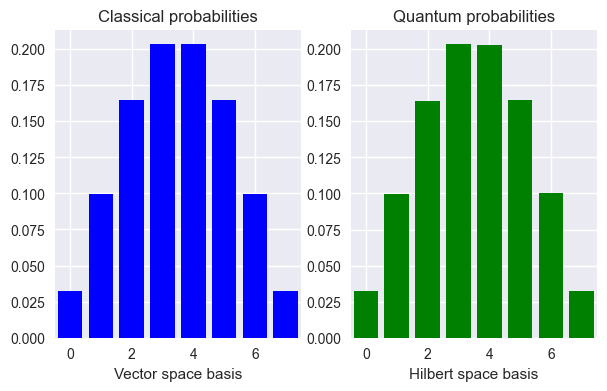

In [ ]:
print("Number of iterations:")
print(len(cost_history))
print("Final weights:")
print(w)

def prepare_and_sample(weights):

    global circ
    circ = QuantumCircuit(n_qubits, n_qubits)

    variational_block(weights)

    circ.measure_all()

    circ = transpile(circ, backend)
    result = backend.run(circ, shots = n_shots).result()

    counts = result.get_counts(circ)
    print(counts)
    return counts

#raw_samples = prepare_and_sample([-0.22296879,  1.39700563, -1.86268021, -1.69595003,  1.33466046,  0.58702013,
# -1.37133891, -0.31573189,  1.67787141])

raw_samples = prepare_and_sample(w)
q_probs = [0 for x in range(2**n_qubits)]
for ind in range(2**n_qubits):
    bind = "{:03b}".format(ind) + " 000"
    # Here we see that we don't need to reverse the results for qiskit's implementation
    q_probs[ind] = (raw_samples[bind] / n_shots) if bind in raw_samples else 0

print("x_n^2 =\n", c_probs)
print("|<x|n>|^2=\n", q_probs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), list(q_probs), color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()


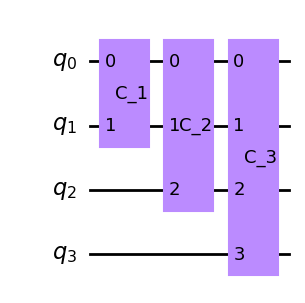

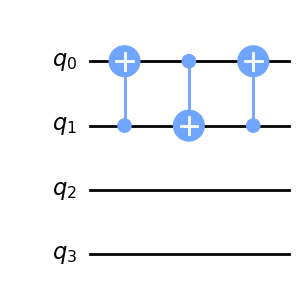

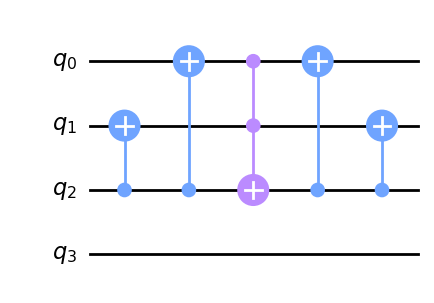

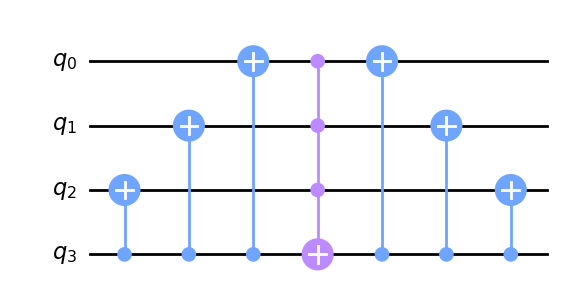

In [ ]:
Cgates = [qiskit.QuantumCircuit(x+2, name=r'C_' + str(x+1)).to_gate() for x in range(4)]

circ = QuantumCircuit(4)
for ind in range(3):
    circ.append(Cgates[ind], [x for x in range(ind+2)])

display(circ.draw('mpl'))

def CI_noc(i):
    global circ
    for j in range(i):
        circ.mcx([i], i-1-j, mode="noancilla")
    circ.mcx([x for x in range(i)], i, mode="noancilla")
    for j in range(i):
        circ.mcx([i], j, mode="noancilla")

global circ
circ = QuantumCircuit(4)
CI_noc(1)
display(circ.draw('mpl'))

circ = QuantumCircuit(4)
CI_noc(2)
display(circ.draw('mpl'))


circ = QuantumCircuit(4)
CI_noc(3)
display(circ.draw('mpl'))